In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [107]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


## Preparation of the dataset and normalizations

In [108]:
df = pd.read_csv("dataset_prepared.csv")

In [109]:
mode_order_mapping = {True: 1, False: 0}
df['explicit'] = df['explicit'].map(mode_order_mapping).astype('Int64')

In [110]:
df.dtypes[df.dtypes.map(lambda x: x == 'object')]

name          object
artists       object
album_name    object
genre         object
dtype: object

In [111]:
df_train = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
df_train = df_train.drop(["key","time_signature", "mode", "explicit"], axis=1)

In [112]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(df_train)
type(df_train)

pandas.core.frame.DataFrame

# K-means

In the foundational k-means algorithm, initial centroids are typically selected at random from the data points. Because of this random initialisation, the clusters generated can differ across multiple runs. 
The centroid of a cluster is generally calculated as the mean of all the points within that cluster. The notion of 'closeness' or similarity between points is determined using metrics like the Euclidean distance (but that require numerical values), cosine similarity, correlation, among others. 

- Partitional clustering approach
- Number of clusters, K, must be specified
- Each cluster is associated with a centroid (center point)
- Each point is assigned to the cluster with the closest centroid
- The basic algorithm is very simple

SSE—> For every data point in a cluster, the error is the distance between the point and the representative (or center) of that cluster. 
With more clusters, points will be, on average, closer to a centroid. 

However, this doesn't necessarily mean that a high K value produces good clustering. As the text suggests, a good clustering with a smaller K might have a lower SSE than a suboptimal clustering with a higher K value. 

It's essential to understand that SSE doesn't inform us about the distances between distinct clusters; instead, it measures the compactness of points within individual clusters 

The goal is to achieve a low SSE with a smaller k:

- Start with the minimum, k=2
- For each (beginning at 2), run the k-means algorithm multiple times on the data.
- For every run, record the resulting SSE.
- Plot the minimum (or best) SSE value for that k.
- Repeat the process by incrementing k (e.g., k=3, 4…).
- Generally, there's no need to use a large k, especially if the dataset is well-suited for centroid-based clustering.


In [113]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [115]:
sse_list = []
sil_list = []

for k in range(2, 51):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(train_data)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(train_data, kmeans.labels_))

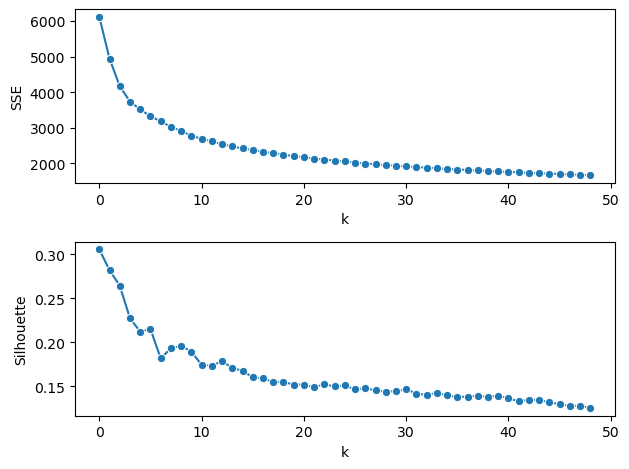

In [116]:
fig, axs = plt.subplots(2) # 1 row, 2 columns
 
sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')
sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')
 
plt.tight_layout() # Adjust the padding between and around subplots
# k= 4 5 6 7

In [191]:
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10, max_iter=100)
kmeans.fit(train_data)

KMeans(max_iter=100, n_clusters=7, n_init=10)

per assegnare ai 4 clusters delle lettere anzi che dei numeri
df['kmeans_labels'] = kmeans.labels_
df['kmeans_labels'] = df['kmeans_labels'].map({0:"A", 1: "B", 2: "C", 3:"D"})

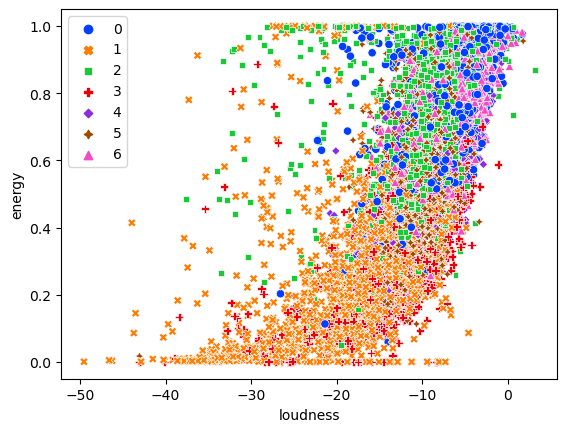

In [192]:
sns.scatterplot(data=df_train, 
                x="loudness",
                y="energy",
                hue=kmeans.labels_,
                style=kmeans.labels_,
                palette="bright")          
plt.show()

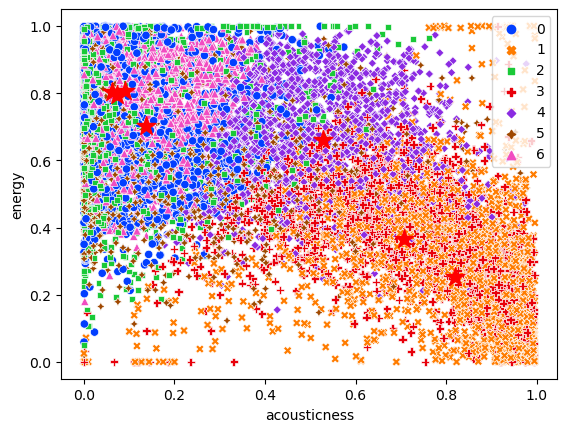

In [193]:
# Calcolo dei centri dei cluster e trasformazione inversa
centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Aggiunta dei label dei cluster al DataFrame originale
df['kmeans_labels'] = kmeans.labels_

# Trova gli indici corrispondenti per 'loudness' e 'energy'
loudness_idx = df_train.columns.get_loc("acousticness")
energy_idx = df_train.columns.get_loc("energy")

# Plot dei dati
sns.scatterplot(data=df, 
                x="acousticness", 
                y="energy", 
                hue='kmeans_labels', 
                style='kmeans_labels',
                palette="bright")

# Plot dei centri dei cluster
plt.scatter(centers[:, loudness_idx], centers[:, energy_idx], c='red', marker='*', s=200)

plt.legend()
plt.show()


In [199]:
df["kmeans_labels"].unique() # Stampo i valori unici del nuovo attributo creato sopra che associa ad ogni row il cluster di riferimento
np.unique(kmeans.labels_, return_counts=True) # stampo il numero di elementi in ogni cluster

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3068, 1652, 1722, 1914, 1945, 1527, 3172]))

In [201]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(train_data, kmeans.labels_))

SSE 3325.2410885285067
Silhouette 0.18952333444255381


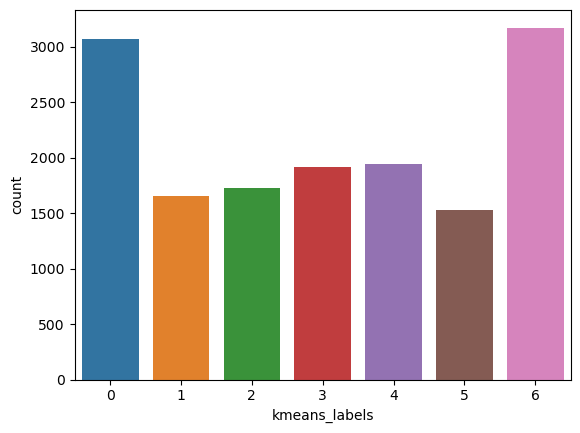

In [205]:
sns.countplot(data=df, x='kmeans_labels')
plt.show()

## Bisecting k-means

Combining the principles of hierarchical clustering with the k-means algorithm. 

- Initialization: Begin with the entire dataset treated as a single cluster
- Bisecting Process: At each iteration, select a cluster to split, only one. The selection is based on a criterion, such as the cluster having the highest Sum of Squared Errors (SSE). Once a cluster is chosen, apply the k-means algorithm with k=2 to divide this cluster into two sub-clusters.
-  Repetition: Continue the process of selecting and bisecting clusters until the desired number of clusters is achieved.


In [202]:
from sklearn.cluster import BisectingKMeans

In [203]:
bkmeans = BisectingKMeans(n_clusters=6, n_init=10, max_iter=100)
bkmeans.fit(train_data)

BisectingKMeans(max_iter=100, n_clusters=6, n_init=10)

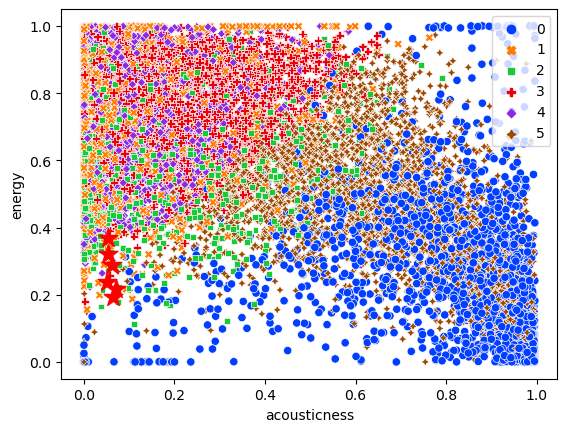

In [211]:
# Assuming that 'bkmeans.labels_' provides the labels for each point after fitting the model
df['bkmeans_labels'] = bkmeans.labels_

# If the Bisecting KMeans algorithm does not provide cluster centers, you will need to compute them
# This is just an example of how you might calculate the centers
# You'd need to modify this to fit your specific case, particularly the indexing into 'train_data'
centers = np.array([train_data[df['bkmeans_labels'] == i].mean(axis=0) for i in range(6)])

# Now you can plot your data points
# Replace 'sepal length (cm)' and 'petal length (cm)' with your actual feature names
sns.scatterplot(data=df, 
                x="acousticness",  # replace with your actual feature
                y="energy",  # replace with your actual feature
                hue='bkmeans_labels', 
                style='bkmeans_labels',
                palette="bright")

# Plot the calculated cluster centers
# Adjust the indexing of 'centers' based on how your features are ordered
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='*', s=200)

plt.legend()
plt.show()


In [208]:
print('SSE', bkmeans.inertia_)
print('Silhouette', silhouette_score(train_data, bkmeans.labels_))

SSE 3582.973378727286
Silhouette 0.19866378629992504


## Hierarchical Clustering

Two types:

- Agglomerative (bottom-up): Start with the points as individual clusters. At each step, merge the closest pair of clusters until only one cluster (or k clusters) left.
- Divisive (top-down): Start with one, all-inclusive cluster. At each step, split a cluster until each cluster contains an individual point (or there are k clusters)

Algorithm:
- Compute the proximity matrix
- Let each data point be a cluster
- Repeat
- Merge the two closest clusters
- Update the proximity matrix
- Until only a single cluster remains

We can define the two closest clusters with 5 possibilities:
- Min function: that the distance between two clusters is the minimum of the distance between their points 
- MAX function: I consider the maximum distance between two points in the clusters. This is best for well-separated clusters. 
- Group average: I consider all distances between points in the two clusters and consider the group average, this is the average of the distance. 
- Distance between Centroids: I compute the average of the two clusters and consider the distance between the two averages (centroids) as the distance between two clusters.
- Ward’s Method: the distance is treated as a variable. Among various algorithms, Ward’s Method stands out as it computes based on the sum of squared errors (SSE). Specifically, two clusters are merged if their combination yields the greatest improvement in SSE. 


In [169]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [177]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=10, n_clusters=None, affinity='euclidean', linkage='ward')
model = model.fit(train_data)

/Users/francescocapria/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


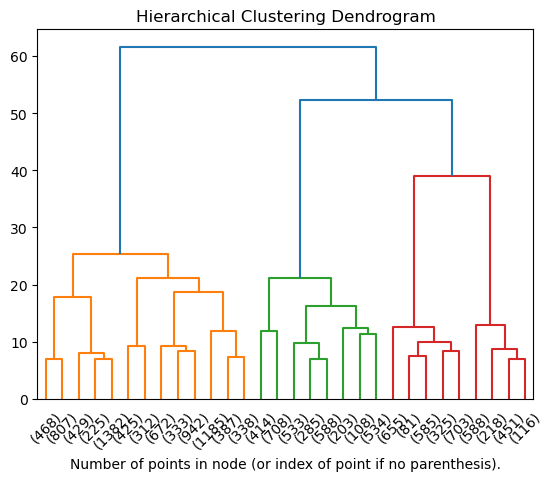

In [178]:
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="lastp")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [179]:
hier = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='complete')
hier.fit(train_data)

/Users/francescocapria/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=3)

In [ ]:
sns.scatterplot(data=df_train:, x="AgeFill", y="Fare", hue=hier.labels_, )
                style=hier.labels_, palette="bright")
plt.show()